I'll follow classification process with https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/notebooks/TripletMarginLossMNIST.ipynb

In [1]:
import time
import logging 

import torch
import torch.nn as nn

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pytorch_metric_learning
from pytorch_metric_learning import losses, miners, samplers, distances, testers, reducers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)

INFO:root:VERSION 0.9.98


_____

In [2]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
        
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [3]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True) # embedding + averaging
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return embedded
    
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [4]:
def train(cur_epoch, dataloader, mining_func):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        embeddings = model(text, offsets)        
        indices_tuple = mining_func(embeddings, label)
        loss = loss_func(embeddings, label, indices_tuple)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
    print("Current Epoch {} : Loss = {}, Number of mined triplets = {}".format(cur_epoch, loss, mining_func.num_triplets))

def get_all_embeddings(loader, model):
    model.eval()
    emb_container = []
    label_container = []

    for idx, (label, text, offsets) in enumerate(loader):
        emb = model(text, offsets)
        emb_container.append(emb.cpu())
        label_container.append(label.cpu())

    x,y = torch.cat(emb_container), torch.cat(label_container)
    return x.detach(), y.detach()

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def evaluate(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

____

In [7]:
tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(device)

# set vocab size
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

INFO:root:File /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/train.csv already exists.
INFO:root:Validating hash b1a00f826fdfbd249f79597b59e1dc12 matches hash of /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/train.csv


cuda


In [8]:
# load nn.Module object
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter])); print(num_class)
vocab_size = len(vocab); print(vocab_size)
emsize = 32
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

INFO:root:File /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/train.csv already exists.
INFO:root:Validating hash b1a00f826fdfbd249f79597b59e1dc12 matches hash of /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/train.csv


4
95812


In [9]:
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

INFO:root:File /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/train.csv already exists.
INFO:root:Validating hash b1a00f826fdfbd249f79597b59e1dc12 matches hash of /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/train.csv
INFO:root:File /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/test.csv already exists.
INFO:root:Validating hash d52ea96a97a2d943681189a97654912d matches hash of /home/hyunsikkim/embedding-research/research/.data/AG_NEWS/test.csv


### generate imbalance data

_____

In [11]:
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [12]:
### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 20)

In [13]:
num_epochs = 10 # epoch

for epoch in range(1, num_epochs+1):
    train(epoch, train_dataloader, mining_func)
    evaluate(train_dataloader, test_dataloader, model, accuracy_calculator)

Current Epoch 1 : Loss = 0.1215323805809021, Number of mined triplets = 54


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8492105263157895
Current Epoch 2 : Loss = 0.08904987573623657, Number of mined triplets = 20


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8707894736842106
Current Epoch 3 : Loss = 0.10061649233102798, Number of mined triplets = 22


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8807894736842106
Current Epoch 4 : Loss = 0.08280385285615921, Number of mined triplets = 17


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8838157894736842
Current Epoch 5 : Loss = 0.10647626221179962, Number of mined triplets = 35


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8864473684210527
Current Epoch 6 : Loss = 0.07528330385684967, Number of mined triplets = 2


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8888157894736842
Current Epoch 7 : Loss = 0.08849599212408066, Number of mined triplets = 12


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8942105263157895
Current Epoch 8 : Loss = 0.09861722588539124, Number of mined triplets = 48


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8926315789473684
Current Epoch 9 : Loss = 0.08755666762590408, Number of mined triplets = 28


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8955263157894737
Current Epoch 10 : Loss = 0.095902219414711, Number of mined triplets = 29


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Computing accuracy
Test set accuracy (Precision@1) = 0.8968421052631579


____

In [14]:
from cycler import cycler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [15]:
model.fc = Identity()

In [16]:
def get_all_embeddings(loader, model):
    model.eval()
    emb_container = []
    label_container = []

    for idx, (label, text, offsets) in enumerate(loader):
        emb = model(text, offsets)
        emb_container.append(emb.cpu())
        label_container.append(label.cpu())

    x,y = torch.cat(emb_container), torch.cat(label_container)
    return x.detach(), y.detach()

In [17]:
# AG_NEWS
label_mapper = {1 : 'World',
2 : 'Sports',
3 : 'Business',
4 : "Sci/Tec"}

In [18]:
embeddings, labels = get_all_embeddings(test_dataloader, model)

In [19]:
tsne_embeddings = TSNE(2).fit_transform(embeddings)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

dict_ = dict()

for l in torch.unique(labels) : 
    tmp = embeddings[labels == l].numpy()
    cs_mat = cosine_similarity(tmp)
    cs_mat[np.tril_indices_from(cs_mat)] = np.nan
    dict_[l] = np.nanmean(cs_mat)

dict_

{tensor(0): 0.6111188,
 tensor(1): 0.7175837,
 tensor(2): 0.5750023,
 tensor(3): 0.647356}

In [22]:
np.mean(list(dict_.values()))

0.63776517

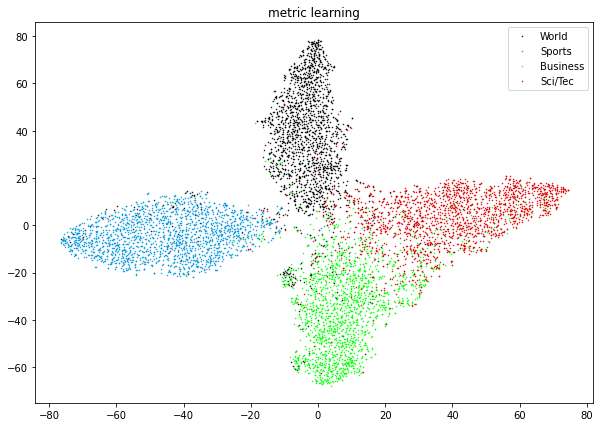

In [24]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes):
    idx = labels == label_set[i]
    str_label = label_mapper[label_set[i]+1]
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=1, label=str_label)
plt.legend()
plt.title("metric learning")
plt.show()

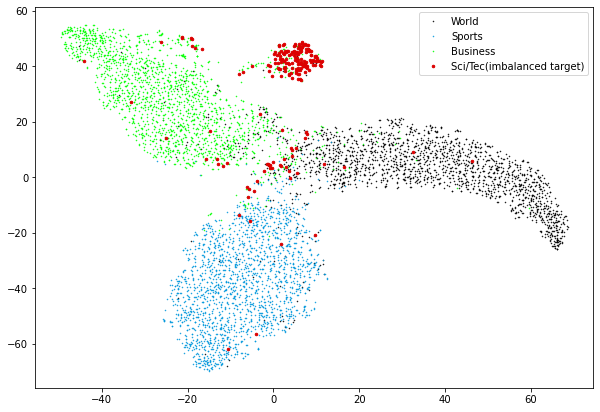

In [153]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes):
    idx = labels == label_set[i]
    str_label = label_mapper[label_set[i]+1]
    str_label = str_label+"(imbalanced target)" if i == 4-1 else str_label
    markersize = 5 if i == 4-1 else 1
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=markersize, label=str_label)
plt.legend()
plt.show()